In [1]:
%load_ext zipline


In [2]:
%zipline ingest --help

Usage: %zipline [OPTIONS]

  Run a backtest for the given algorithm.

Options:
  -f, --algofile FILENAME         The file that contains the algorithm to run.
  -t, --algotext TEXT             The algorithm script to run.
  -D, --define TEXT               Define a name to be bound in the namespace
                                  before executing the algotext. For example
                                  '-Dname=value'. The value may be any python
                                  expression. These are evaluated in order so
                                  they may refer to previously defined names.
  --data-frequency [minute|daily]
                                  The data frequency of the simulation.
                                  [default: daily]
  --capital-base FLOAT            The starting capital for the simulation.
                                  [default: 10000000.0]
  -b, --bundle BUNDLE-NAME        The data bundle to use for the simulation.
                          

In [11]:
%%zipline --bundle yahoo-bundle --trading-calendar XNSE --start '2017-01-02' --end '2019-12-13' --capital-base 10000000 -o nse_2year_rolling.pickle
from zipline.data import bundles
import os
import pandas as pd
from zipline.data.bundles import register, load
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data.bundles.yahoo import yahoo_stock_data
from zipline.data.data_portal import DataPortal
from zipline import run_algorithm
from zipline.api import schedule_function
from zipline.pipeline.data import Column
from zipline.pipeline.pipeline import Pipeline
from zipline.api import *
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
from trading_calendars.trading_calendar import TradingCalendar
from trading_calendars import get_calendar
import itertools
from zipline.pipeline.filters import StaticAssets

# Import visualization
import matplotlib.pyplot as plt

from zipline.utils.events import (
  date_rules,
  time_rules,
  Always,
  ComposedRule,
  Never,
  OncePerDay,
)
from zipline.api import (
  attach_pipeline,
  date_rules,
  order_target_percent,
  pipeline_output,
  record,
  schedule_function,
  symbols,
  symbol,
  sid,
)

start_session=pd.Timestamp('2017-01-02', tz='utc')
end_session=pd.Timestamp('2019-12-13', tz='utc')
import numpy as np
from scipy import stats
from zipline.api import order_target, record, symbol

register('yahoo-bundle',yahoo_stock_data,
    calendar_name="XNSE",
    start_session=start_session,
    end_session=end_session
)


bundle=load('yahoo-bundle')
all_assets=bundle.asset_finder.retrieve_all(bundle.asset_finder.sids)
# create a python set
symbols=set(
  str(asset.symbol) for asset in bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids)
)

list_symbols=list(symbols)
# print(type(list_symbols))
# print("list of symbols", list_symbols)
data_por=DataPortal(bundle.asset_finder,
                    get_calendar("XNSE"),
                    bundle.equity_daily_bar_reader.first_trading_day,
                    equity_minute_reader=bundle.equity_minute_bar_reader,
                    equity_daily_reader=bundle.equity_daily_bar_reader,
                    adjustment_reader=bundle.adjustment_reader)

close_prices=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                     pd.Timestamp('2007-02-02', tz='utc'), 'daily')
close_prices_list=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                          pd.Timestamp('2017-12-31', tz='utc'), 'daily')

list_sids=list(bundle.asset_finder.sids)


# print((close_prices))


def _slope(ts):
  x=np.arange(len(ts))
  slope, intercept, r_value, p_value, std_err=stats.linregress(x, ts)
  annualized_slope=(np.power(np.exp(slope), 250)-1)*100
  return annualized_slope*(r_value**2)


def initialize(context):
  """
  Called once at the start of the algorithm.
  """
  # Setting global parameters
  # context.assets = symbol('3MINDIA')
  context.last_month = 10000000
  context.market=symbol('NIFTY.NS')
  context.market_window=200
  context.momentum_window=90
  context.minimum_momentum=30
  context.number_of_stocks=10
  # --------------------------

  """Set
  up
  pipeline
  engine"""

  # Loader for pricing
  pipeline_loader=USEquityPricingLoader(
    bundle.equity_daily_bar_reader,
    bundle.adjustment_reader,
  )

  def choose_loader(column):
    if column in USEquityPricing.columns:
      return pipeline_loader

    raise ValueError(
      'No PipelineLoader registered for column %s.'%column
    )

  engine=SimplePipelineEngine(
    get_loader=choose_loader,
    calendar=get_calendar("XNSE").all_sessions,
    asset_finder=bundle.asset_finder,
  )

  pipe=make_pipeline()

  results=engine.run_pipeline(pipe,
                              pd.to_datetime('2017-01-02', utc=True),
                              pd.to_datetime('2019-12-13', utc=True))

  # print(results.head(1200))
  context.pipeline_data=results
  # print("type results",type(results))
  # Create our dynamic stock selector.
  attach_pipeline(pipe, 'make_pipeline')

  # Rebalance monthly
  # schedule_function(my_rebalance, date_rules.month_start(), time_rules.market_open(hours=1))

  """close_prices_list=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                          pd.Timestamp('2018-12-03', tz='utc'), 'daily')"""

  # print("type of close prices", type(close_prices_list))
  #schedule_function(my_rebalance, date_rules.week_end(days_offset=2))
  schedule_function(my_rebalance, date_rules.month_end())


#

def output_progress(context):
    """
    Output some performance numbers during backtest run
    This code just prints out the past month's performance
    so that we have something to look at while the backtest runs.
    """
    from zipline.api import get_datetime
    
    # Get today's date
    today = get_datetime().date()
    
    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value


def make_pipeline():
  """
  This will return the top 500 US stocks by market cap, dynically updated.
  """
  # Base universe set to the Q500US
  base_universe=(StaticAssets(all_assets))

  # print(type(base_universe))
  yesterday_close=close_prices_list

  pipe=Pipeline(
    screen=base_universe,
    columns={
      'close': USEquityPricing.close.latest,
      'volume': USEquityPricing.volume.latest,
      'open': USEquityPricing.open.latest,
    }
  )
  return pipe


def get_change(current, previous):
  if current==previous:
    return 100.0
  try:
    return ((current-previous)/previous)*100.0
  except ZeroDivisionError:
    return 0


def before_trading_start(context, data):
  print("inside before trading start")
  # context.pipeline_data=pipeline_output(name='make_pipeline')


def handle_data(context, data):
  # context.pipeline_data=pipeline_output('make_pipeline')
  # window_1 = data.history(context.assets,'high',1, '1d')
  # print(window_1)
  # schedule_function(my_rebalance(context, data), date_rules.week_end(days_offset=3))
  pass


def my_rebalance(context, data):
  """
  Our monthly rebalancing
  """

  output_progress(context)
  # context.pipeline_data=pipeline_output('us_500')
  # context.output=pipeline_output('us_500')  # update the current top 500 us stocks
  # context.pipeline_data=pipeline_output('us_500')
  algo_run_timestamp=str(context.datetime)+"T00:00.000000000"
  print("has hit rebalance on date", algo_run_timestamp)
  market_history=data.history(context.market, "close", context.market_window, "1d")  ##NIFTY##
  market_price_algo_day=market_history.get(algo_run_timestamp)
  market_sma_200=data.history(context.market, 'close', bar_count=200, frequency="1d").mean()
  market_cond=market_price_algo_day>market_sma_200
  market_chg=get_change(market_price_algo_day, market_sma_200)
  #print("market chg is", market_chg)
  market_chg_cond=(market_chg<0.5)
  if (market_chg_cond):
    #print(str(algo_run_timestamp))
    print("nothing to buy this month")
    return

  my_dict={}
  for x in range(len(list_sids)):
    my_dict[x]=sid(list_sids[x])

  context.security_list=list(my_dict.values())

  momentum_list=np.log(data.history(context.security_list, "close", context.momentum_window, "1d")).apply(_slope)

  # print("momentum list is", momentum_list.sort_values(ascending=False))
  ranking_table=momentum_list.sort_values(ascending=False)  # Sorted

  # print("price at a particular time",market_history.get(algo_run_timestamp))

  # print("market history",market_history)
  # market details
  #print("Nifty current price and 200Sma", market_price_algo_day, market_sma_200)
  buy_list=ranking_table[:context.number_of_stocks]  # These we want to buy
  #print("buy list", buy_list)
  #print("context portfolio positions", context.portfolio.positions)
  # Let's trade!
  for security in context.portfolio.positions:
    if security not in buy_list:
      #print("making this", security, 0)
      order_target(security, 0)  # If a stock in the portfolio is not in buy list, sell it!

  for security in context.security_list:
    if security in buy_list:
      sma_100=data.history(security, 'price', bar_count=100, frequency="1d").mean()
      sma_50=data.history(security, 'price', bar_count=50, frequency="1d").mean()
      #print("security details", security)

      if buy_list[security]<context.minimum_momentum:
        weight=0.0
      else:
        weight=1.0/context.number_of_stocks  # Equal size to keep simple
      cond1=sma_50>sma_100
      cond2=market_price_algo_day>market_sma_200
      #print("security 50 and 100 sma", sma_50, sma_100)

      if (cond1 and cond2):
        order_target_percent(security, weight)  # Trade!
        #print("ordering this", security)

      
        


<string>:53: UserWarning: Overwriting bundle with name 'yahoo-bundle'


2017-01-31 - Last Month Result: 0.00%
has hit rebalance on date 2017-01-31 10:00:00+00:00T00:00.000000000
2017-02-28 - Last Month Result: -2.51%
has hit rebalance on date 2017-02-28 10:00:00+00:00T00:00.000000000
2017-03-31 - Last Month Result: 7.41%
has hit rebalance on date 2017-03-31 10:00:00+00:00T00:00.000000000
2017-04-28 - Last Month Result: 13.16%
has hit rebalance on date 2017-04-28 10:00:00+00:00T00:00.000000000
2017-05-31 - Last Month Result: 3.98%
has hit rebalance on date 2017-05-31 10:00:00+00:00T00:00.000000000
2017-06-30 - Last Month Result: 12.69%
has hit rebalance on date 2017-06-30 10:00:00+00:00T00:00.000000000
2017-07-31 - Last Month Result: 6.22%
has hit rebalance on date 2017-07-31 10:00:00+00:00T00:00.000000000
2017-08-31 - Last Month Result: 13.37%
has hit rebalance on date 2017-08-31 10:00:00+00:00T00:00.000000000
2017-09-29 - Last Month Result: 14.07%
has hit rebalance on date 2017-09-29 10:00:00+00:00T00:00.000000000
2017-10-31 - Last Month Result: 35.91%
ha

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-02 10:00:00+00:00,NaN,0.000000,NaN,0.002821,NaN,NaN,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,1,[],0.0
2017-01-03 10:00:00+00:00,0.000000,0.000000,0.000000,0.006580,0.010411,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,2,[],0.0
2017-01-04 10:00:00+00:00,0.000000,0.000000,0.000000,0.006867,0.028467,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,3,[],0.0
2017-01-05 10:00:00+00:00,0.000000,0.000000,0.000000,0.017772,0.071705,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,4,[],0.0
2017-01-06 10:00:00+00:00,0.000000,0.000000,0.000000,0.014364,0.083061,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,5,[],0.0
2017-01-09 10:00:00+00:00,0.000000,0.000000,0.000000,0.014657,0.076148,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,6,[],0.0
2017-01-10 10:00:00+00:00,0.000000,0.000000,0.000000,0.021395,0.073946,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,7,[],0.0
2017-01-11 10:00:00+00:00,0.000000,0.000000,0.000000,0.033131,0.083289,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,8,[],0.0
2017-01-12 10:00:00+00:00,0.000000,0.000000,0.000000,0.035666,0.078392,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,9,[],0.0
2017-01-13 10:00:00+00:00,0.000000,0.000000,0.000000,0.035158,0.077144,0.000000,0.000000e+00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,10,[],0.0


In [ ]:
# result = run_algorithm(
#     start=start_session, 
#     end=end_session, 
#     initialize=initialize, 
#     analyze=analyze, 
#     handle_data=handle_data, 
#     capital_base=100000, 
#     data_frequency = 'daily', 
#     bundle='yahoo-bundle',
   
# ) 


In [12]:
import pandas as pd
perf = pd.read_pickle('nse_2year_rolling.pickle') # read in perf DataFrame

In [13]:
# Import visualization
import matplotlib.pyplot as plt
def analyze(perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.semilogy(perf['portfolio_value'], linestyle='-', 
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], 
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)  

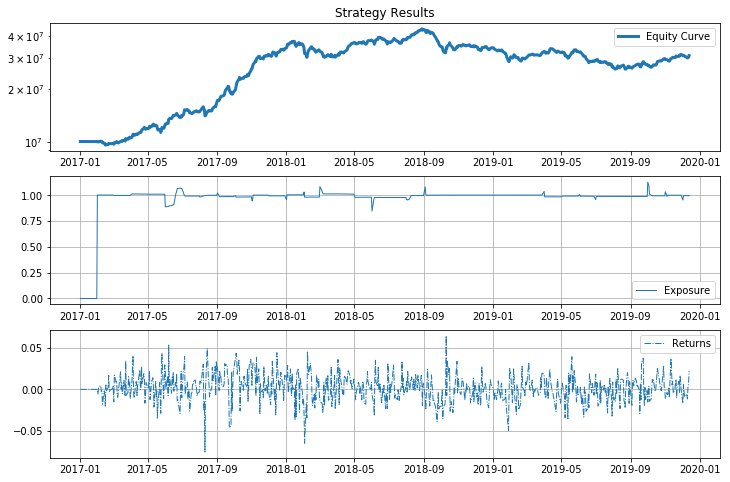

In [14]:
analyze(perf)

In [15]:
perf.to_csv("results.csv")

In [16]:
import pandas as pd
import pyfolio as pf

In [18]:
results = pd.read_pickle('nse_2year_rolling.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [19]:
rts = pf.round_trips.extract_round_trips(transactions, portfolio_value=positions.sum(axis='columns') / (returns + 1))
pf.round_trips.print_round_trip_stats(rts)

ValueError: cannot insert dt, already exists

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5, 0, 'Date')

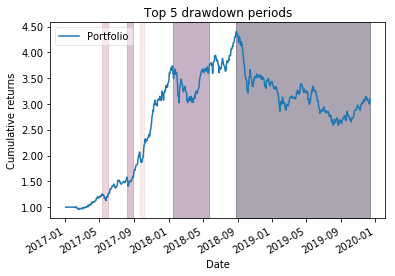

In [20]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

Start date,2017-01-02
End date,2019-12-13
Total months,34
,Backtest
Annual return,48.2%
Cumulative returns,209.4%
Annual volatility,25.7%
Sharpe ratio,1.66
Calmar ratio,1.17
Stability,0.48
Max drawdown,-41.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.22,2018-08-28,2019-08-23,NaT,NaN
1,19.06,2018-01-15,2018-02-06,2018-05-25,95
2,11.26,2017-08-07,2017-08-10,2017-08-28,16
3,10.28,2017-05-11,2017-05-24,2017-06-01,16
4,9.88,2017-09-20,2017-09-27,2017-10-05,12


Stress Events,mean,min,max
New Normal,0.17%,-7.59%,6.50%


Top 10 long positions of all time,max
sid,
IBULISL.NS,20.20%
KIOCL.NS,18.72%
IBVENTURES.NS,17.73%
ASTRAZEN.NS,15.60%
ITI.NS,15.30%
ADANIGREEN.NS,14.49%
HDFCAMC.NS,14.44%
BAJFINANCE.NS,14.34%
HEG.NS,13.49%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
IBULISL.NS,20.20%
KIOCL.NS,18.72%
IBVENTURES.NS,17.73%
ASTRAZEN.NS,15.60%
ITI.NS,15.30%
ADANIGREEN.NS,14.49%
HDFCAMC.NS,14.44%
BAJFINANCE.NS,14.34%
HEG.NS,13.49%


/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:90: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pyfolio/round_trips.py:379: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in

Summary stats,All trades,Long trades
Total number of round_trips,231.00,231.00
Percent profitable,0.66,0.66
Winning round_trips,153.00,153.00
Losing round_trips,78.00,78.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$20948319.95,$20948319.95
Gross profit,$47194891.18,$47194891.18
Gross loss,$-26246571.23,$-26246571.23
Profit factor,$1.80,$1.80
Avg. trade net profit,$90685.37,$90685.37
Avg. winning trade,$308463.34,$308463.34
Avg. losing trade,$-336494.50,$-336494.50
Ratio Avg. Win:Avg. Loss,$0.92,$0.92
Largest winning trade,$4655322.41,$4655322.41
Largest losing trade,$-2374601.94,$-2374601.94


Duration stats,All trades,Long trades
Avg duration,77 days 06:25:27.316017,77 days 06:25:27.316017
Median duration,60 days 00:00:00,60 days 00:00:00
Longest duration,307 days 00:00:00,307 days 00:00:00
Shortest duration,10 days 14:00:01,10 days 14:00:01


Return stats,All trades,Long trades
Avg returns all round_trips,0.35%,0.35%
Avg returns winning,1.12%,1.12%
Avg returns losing,-1.15%,-1.15%
Median returns all round_trips,0.16%,0.16%
Median returns winning,0.57%,0.57%
Median returns losing,-0.54%,-0.54%
Largest winning trade,12.67%,12.67%
Largest losing trade,-7.40%,-7.40%


Symbol stats,LALPATHLAB.NS,UJJIVAN.NS,BBTC.NS,MANAPPURAM.NS,LAXMIMACH.NS,MOTILALOFS.NS,INFIBEAM.NS,ISEC.NS,TATAELXSI.NS,ZENSARTECH.NS,BEML.NS,BALRAMCHIN.NS,COLPAL.NS,VAKRANGEE.NS,SWANENERGY.NS,PIDILITIND.NS,SUVEN.NS,KOLTEPATIL.NS,GLAXO.NS,HDFCAMC.NS,FCONSUMER.NS,JPASSOCIAT.NS,TRENT.NS,MINDTREE.NS,GRAPHITE.NS,MINDAIND.NS,SONATSOFTW.NS,INDIGO.NS,HSCL.NS,ORIENTCEM.NS,FLFL.NS,RCOM.NS,RADICO.NS,ITDC.NS,HFCL.NS,MOIL.NS,ASTRAZEN.NS,JINDALSTEL.NS,DCMSHRIRAM.NS,TAKE.NS,BIOCON.NS,NFL.NS,ITI.NS,AVANTIFEED.NS,BALMLAWRIE.NS,DMART.NS,BPCL.NS,JAICORPLTD.NS,HEG.NS,KIOCL.NS,ADANIGREEN.NS,RUPA.NS,J&KBANK.NS,CHOLAFIN.NS,JUBLFOOD.NS,SUNTECK.NS,YESBANK.NS,CAPLIPOINT.NS,BANDHANBNK.NS,FRETAIL.NS,IFBIND.NS,BAJFINANCE.NS,DIXON.NS,PHILIPCARB.NS,IBREALEST.NS,JSL.NS,INOXLEISUR.NS,VIPIND.NS,CREDITACC.NS,JUSTDIAL.NS,LTI.NS,TCS.NS,RNAM.NS,PAGEIND.NS,DBL.NS,IBULISL.NS,HDFCLIFE.NS,KRBL.NS,WELSPUNIND.NS,ASHOKLEY.NS,EXCELCROP.NS,WELCORP.NS,CESC.NS,VMART.NS,MAHSCOOTER.NS,PCJEWELLER.NS,PNCINFRA.NS,ADANITRANS.NS,PRAJIND.NS,GUJALKALI.NS,INTELLECT.NS,GODFRYPHLP.NS,FSL.NS,RECLTD.NS,NIITTECH.NS,MINDACORP.NS,BERGEPAINT.NS,ADANIPOWER.NS,CHAMBLFERT.NS,SHANKARA.NS,APLAPOLLO.NS,BRIGADE.NS,RAIN.NS,VENKEYS.NS,TECHM.NS,JKCEMENT.NS,GRUH.NS,AAVAS.NS,SBILIFE.NS,SCI.NS,BATAINDIA.NS,BOMDYEING.NS,ZYDUSWELL.NS,NATIONALUM.NS,IBVENTURES.NS
Avg returns all round_trips,0.82%,-0.67%,0.26%,0.88%,-0.58%,-0.53%,-1.02%,0.55%,0.05%,0.13%,0.26%,0.06%,-0.45%,-1.50%,-1.07%,0.09%,1.11%,-0.57%,-1.19%,1.51%,-0.28%,-1.28%,1.31%,0.84%,0.06%,0.61%,0.58%,0.59%,1.47%,-0.63%,2.83%,-3.78%,1.22%,0.20%,1.18%,-0.31%,0.59%,-0.55%,0.50%,-1.56%,0.52%,0.61%,2.28%,1.15%,-0.55%,-0.01%,-0.43%,-0.69%,0.81%,0.80%,2.29%,0.28%,-1.88%,-0.72%,-0.19%,0.31%,-3.70%,-0.40%,-2.77%,0.93%,0.09%,1.31%,0.82%,2.18%,-0.81%,-0.50%,-0.45%,-2.86%,0.08%,-0.98%,1.68%,0.34%,-0.13%,-3.33%,1.52%,4.18%,-0.45%,0.48%,-0.30%,-0.63%,-0.12%,-0.18%,0.33%,0.90%,-0.12%,-4.33%,-0.50%,0.18%,-1.19%,-0.20%,-3.40%,-1.13%,0.73%,-0.02%,1.32%,-0.41%,0.72%,0.69%,0.59%,0.72%,-0.12%,0.06%,1.48%,1.39%,0.55%,0.26%,-1.25%,0.65%,1.85%,0.27%,0.55%,4.08%,0.03%,-0.78%,1.31%
Avg returns winning,0.82%,nan%,0.26%,0.88%,nan%,nan%,0.11%,0.55%,0.05%,0.13%,0.26%,0.06%,nan%,0.47%,nan%,0.09%,1.11%,nan%,nan%,1.51%,nan%,nan%,1.31%,0.84%,1.92%,0.61%,0.58%,1.22%,1.47%,nan%,2.83%,nan%,1.22%,0.43%,1.18%,nan%,0.59%,nan%,0.50%,nan%,0.52%,0.61%,2.28%,1.15%,nan%,0.22%,nan%,nan%,2.08%,1.02%,2.29%,0.28%,nan%,nan%,nan%,0.31%,nan%,nan%,nan%,0.93%,0.09%,1.31%,0.82%,2.18%,1.13%,nan%,nan%,nan%,0.08%,nan%,1.68%,0.34%,nan%,nan%,1.52%,4.18%,nan%,0.97%,nan%,nan%,nan%,nan%,0.33%,0.90%,0.05%,nan%,nan%,0.27%,nan%,nan%,nan%,nan%,0.73%,nan%,1.32%,nan%,0.72%,0.69%,0.59%,0.72%,nan%,0.06%,1.48%,1.39%,0.55%,0.26%,nan%,0.65%,1.85%,0.27%,0.55%,4.08%,0.09%,nan%,1.71%
Avg returns losing,nan%,-0.67%,nan%,nan%,-0.58%,-0.53%,-2.15%,nan%,nan%,nan%,nan%,nan%,-0.45%,-2.48%,-1.07%,nan%,nan%,-0.57%,-1.19%,nan%,-0.28%,-1.28%,nan%,nan%,-7.40%,nan%,nan%,-0.04%,nan%,-0.63%,nan%,-3.78%,nan%,-0.04%,nan%,-0.31%,nan%,-0.55%,nan%,-1.56%,nan%,nan%,nan%,nan%,-0.55%,-0.25%,-0.43%,-0.69%,-6.82%,-0.02%,nan%,nan%,-1.88%,-0.72%,-0.19%,nan%,-3.70%,-0.40%,-2.77%,nan%,nan%,nan%,nan%,nan%,-3.71%,-0.50%,-0.45%,-2.86%,nan%,-0.98%,nan%,nan%,-0.13%,-3.33%,nan%,nan%,-0.45%,-0.00%,-0.30%,-0.63%,-0.12%,-0.18%,nan%,nan%,-0.17%,-4.33%,-0.50%,-0.00%,-1.19%,-0.20%,-3.40%,-1.13%,nan%,-0.02%,nan%,-0.41%,nan%,nan%,nan%,nan%,-0.12%,nan%,nan%,nan%,nan%,nan%,-1.25%,nan%,nan%,nan%,nan%,nan%,-0.02%,-0.78%,-1.88%
Median returns all round_trips,0.82%,-0.67%,0.26%,0.88%,-0.58%,-0.53%,-1.02%,0.55%,0.05%,0.13%,0.26%,0.06%,-0.45%,-0.97%,-1.07%,0.09%,1.11%,-0.80%,-1.19%,1.01%,-0.28%,-1.28%,1.31%,0.84%,0.66%,0.61%,0.09%,0.59%,1.47%,-0.63%,2.83%,-3.78%,0.30%,0.20%,1.18%,-0.31%,0.58%,-0.55%,0.50%,-1.56%,0.52%,0.61%,1.97%,0.33%,-0.55%,-0.01%,-0.43%,-0.69%,0.87%,0.44%,2.29%,0.28%,-1.88%,-0.72%,-0.19%,0.07%,-3.70%,-0.40%,-2.77%,0.93%,0.06%,1.31%,0.82%,2.18%,0.10%,-0.50%,-0.45%,-2.86%,0.08%,-0.98%,1.68%,0.34%,-0.13%,-3.33%,1.52%,1.91%,-0.45%,0.48%,-0.30%,-0.63%,-0.12%

Profitability (PnL / PnL total) per name,
symbol,
IBULISL.NS,35.98%
KIOCL.NS,15.11%
IBVENTURES.NS,11.19%
RAIN.NS,9.96%
HEG.NS,9.35%
ADANIGREEN.NS,6.69%
BOMDYEING.NS,6.61%
HDFCAMC.NS,6.43%
RADICO.NS,6.40%


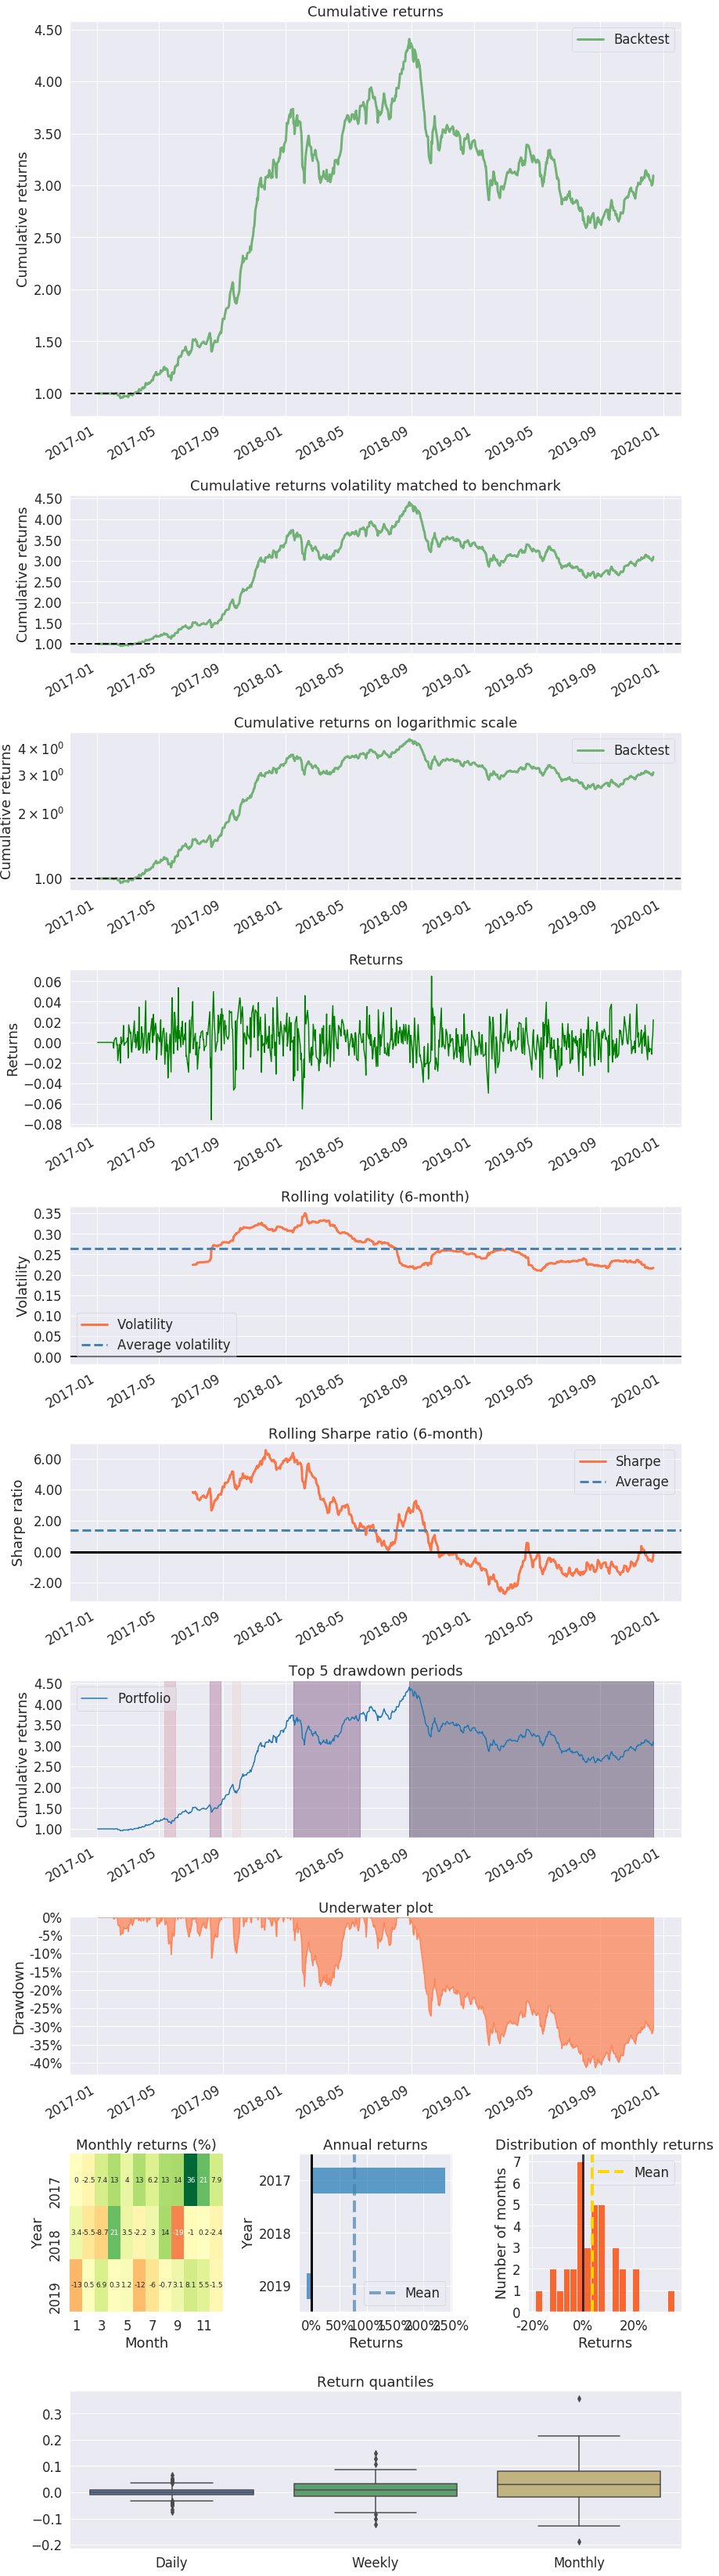

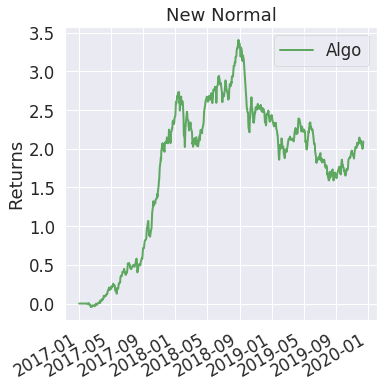

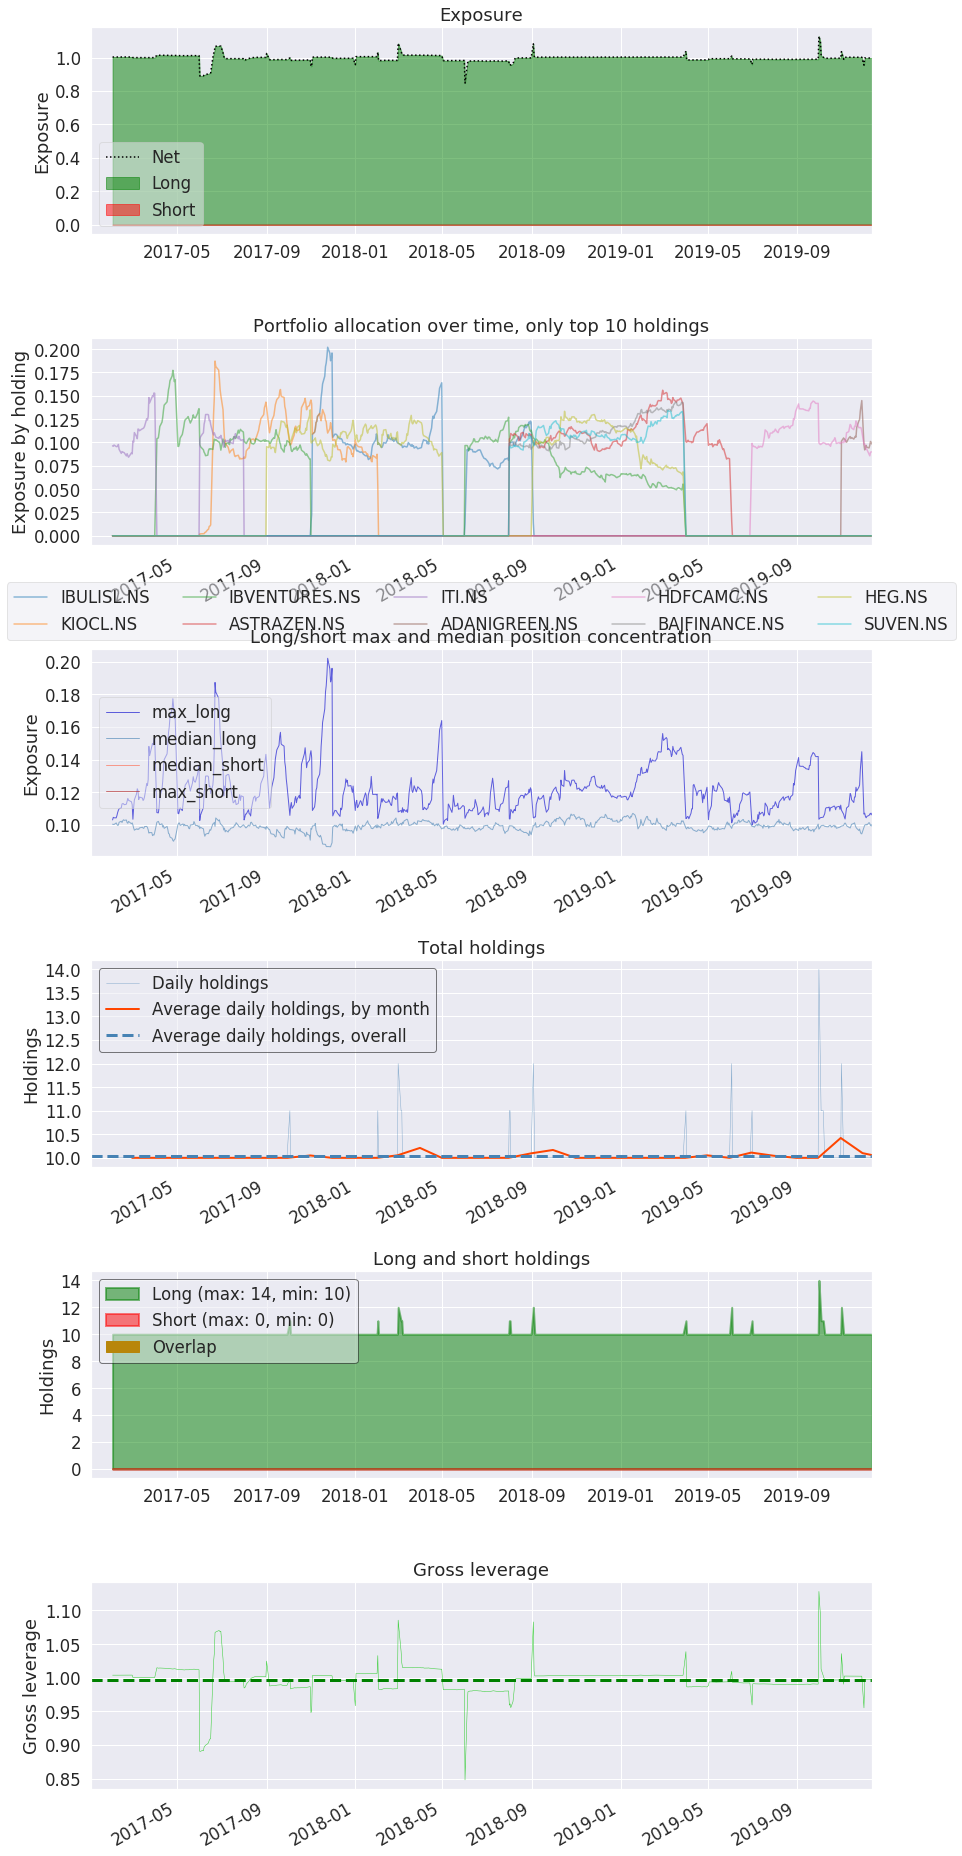

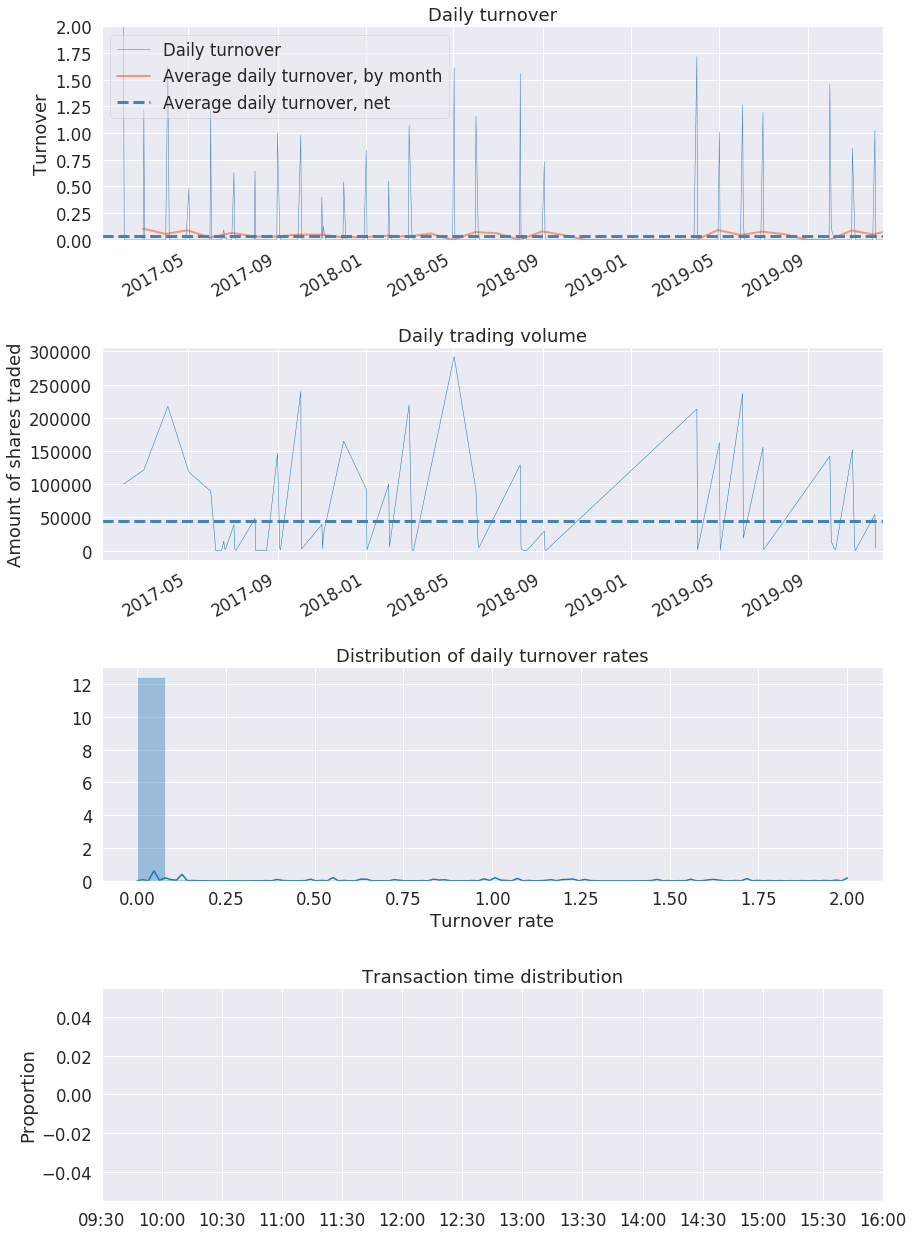

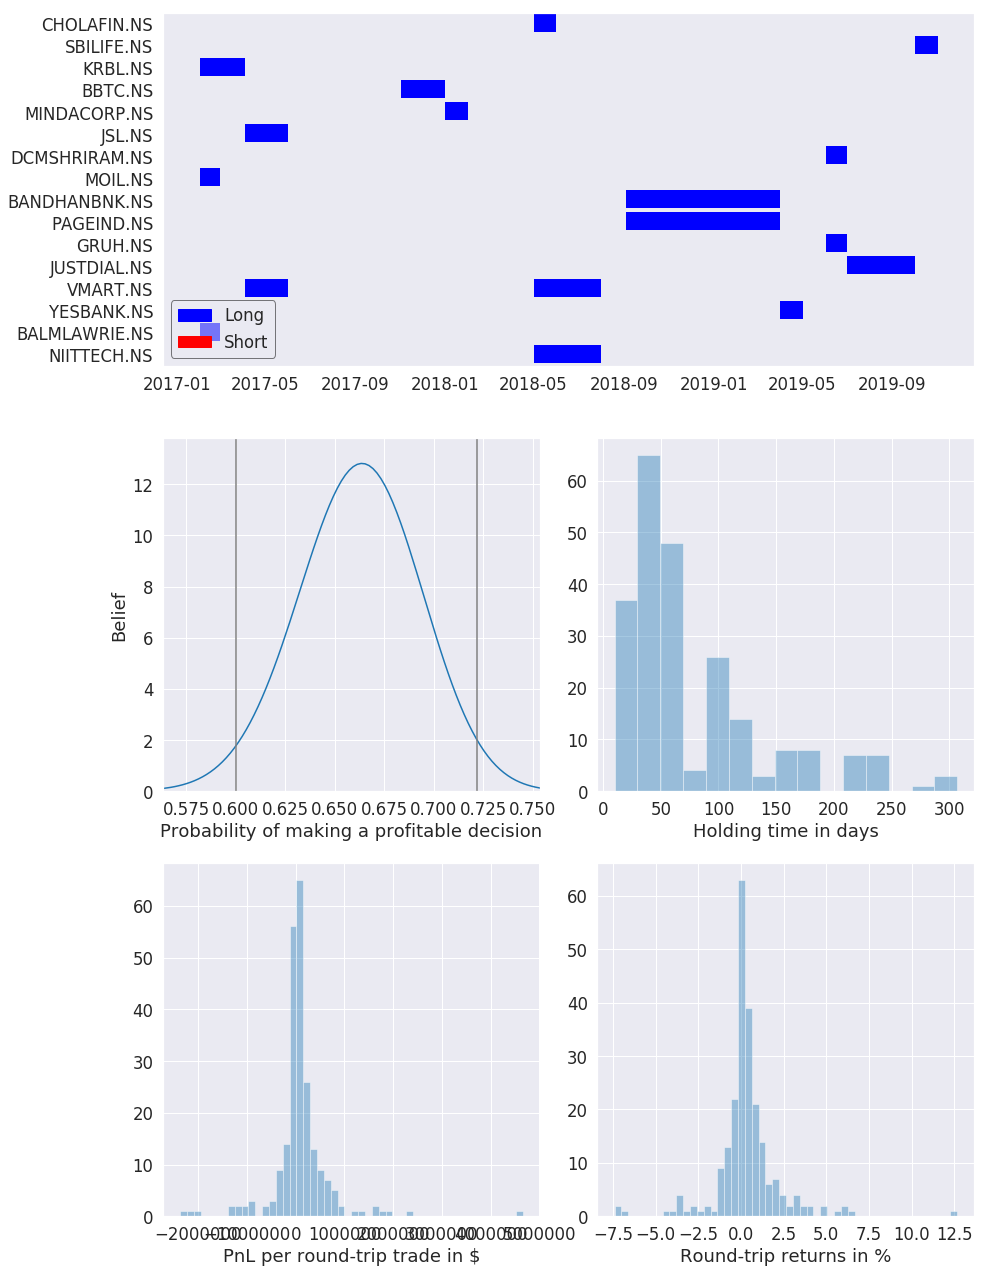

In [21]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, round_trips=True)

In [ ]:
# Custom Time Series Analysis

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt, rc, ticker

# Format for book image
font = {'family' : 'eurostile',
        'weight' : 'normal',
        'size'   : 16}
rc('font', **font)

# Settings
calc_window = 126
year_length = 252

# Copy the columns we need
df = perf.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = perf.portfolio_value.rolling(calc_window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)




In [ ]:
transactions = pd.read_csv('results.csv',index_col=0, parse_dates=True)
positions = pd.read_csv('results.csv',index_col=0, parse_dates=True)


In [ ]:
returns = pd.read_csv('results.csv',index_col=0, parse_dates=True, header=None)[1]

In [ ]:
rts = pf.round_trips.extract_round_trips(transactions, 
                                         portfolio_value=positions.sum(axis='columns') / (returns + 1))

In [ ]:
transactions.columns


In [ ]:
def ann_ret(ts):
    
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1 


# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

In [ ]:
calc_window = 126
year_length = 252
rolling_window = results.portfolio_value.rolling(calc_window)
# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100
ax = fig.add_subplot(411)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Add legend and grid
ax.legend()
ax.grid(True)


In [ ]:
df['annualized'].values

In [ ]:
type(df['annualized'])